In [3]:
import numpy as np
import os
import subprocess
#import theano
import gzip

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import regularizers

import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Conv1D, BatchNormalization, Flatten
from keras.optimizers import Adagrad, Adam
from keras.utils import plot_model
from keras import regularizers

from keras.utils import plot_model
#import matplotlib.pyplot as plt
import pickle
from keras.models import load_model


In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [4]:
TRAIN_PATH = 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'
TEST_PATH =  'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

In [5]:
def load_gz(path):  # load a .npy.gz file
    if path.endswith(".gz"):
        f = open(path, 'rb')
        return np.load(f)
    else:
        return np.load(path)

In [6]:
def get_train(path=TRAIN_PATH):
    
    X_in = load_gz(path)
    print(X_in.shape)
    X = np.reshape(X_in, (5534, 700, 57))
    del X_in
    X = X[:, :, :].astype(theano.config.floatX)
  
    seq_names = np.arange(0, np.size(X, 0))

    #X_train = X[seq_names[0:5278]]
    X_train = X[seq_names[0:5534]] #this is used for utilising the entire dataset as train
    X_valid = X[seq_names[5278:5534]]
    
    return X_train, X_valid

In [7]:
X_train, X_valid= get_train(TRAIN_PATH)
print("Done loading train")
print(X_train.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'

In [8]:
def get_test(path=TEST_PATH):
    
    X_test_in = load_gz(path)
    X_test = np.reshape(X_test_in, (514, 700, 57))
    del X_test_in
    X_test = X_test[:, :, :].astype(theano.config.floatX)

    return X_test

In [9]:
X_test = get_test(TEST_PATH)
print("Done loading test")
print(X_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

In [10]:
#To do: Make 1 hot encoded class - from Q8 to Q3
       #Reshape the dataset so it has 700*windowSize seq that map to a class
       #Look inside lasagne to see how we disregard the padding
##

def q8ClassToQ3(q8Labels):
    
    q3 = np.zeros(3)
    index = np.argmax(q8Labels)
    
    #Helix
    if index == 5 or index == 3 or index == 4 : # H ,G, I
        q3[0] = 1   
    #beta    
    if index == 1 or index == 2: # B, E
        q3[1] = 1    
    #coil    
    if index == 7 or index == 6 or index == 0 : # T, S, L
        q3[2] = 1
    return q3

def q8ClassToQ2(q8Labels):
    
    q2 = np.zeros(2)
    index = np.argmax(q8Labels)
    #Helix
    if index == 5: # or index == 3 or index == 4 : # H ,G, I
        q2[0] = 1
    else:
        q2[1] = 1  
    return q2

def q8toQ8(q8Labels):
    return q8Labels

def changeQ8Class(dataSet, reductionFunction, numberOfFeatures):

    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    labels_new = np.zeros((num_seqs, seqlen, numberOfFeatures))

    for i in range(np.size(dataSet, axis=0)):
        for j in range(np.size(dataSet, axis=1)):
            oneHot = reductionFunction(dataSet[i, j, 22:30])
            features = np.concatenate((dataSet[i, j, 0:21], oneHot), axis=None)
            features = np.concatenate((features, dataSet[i, j, 35:56]), axis=None)
            labels_new[i][j] = features
    return labels_new


In [11]:
def swapClassLabel(features, classLabel, classSize):

    res = np.concatenate((features[0:21], classLabel), axis=None)
    res = np.concatenate((res, features[ (21+classSize) :]), axis=None)
  
    return res

In [12]:
import math

#num_classes should be q8, q3 or maybe q2?
def proteinSequenceToWindowSequence(windowSize, predictionIndex , dataSet, classSize):
   
    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    features = np.size(dataSet, 2)
    dataSet_new = np.zeros((num_seqs, seqlen - windowSize + 1, windowSize, features))
    
    for i in range(np.size(dataSet, axis=0)):
        if i % 100 == 0:
            print(i)
        for j in range(np.size(dataSet, axis=1) - windowSize):
            classLabel = dataSet[i][j + predictionIndex][21 : (21+classSize) ]
            for k in range(windowSize):
                if predictionIndex != 0:
                    dataSet_new[i][j][k] = swapClassLabel(dataSet[i][j+k], classLabel, classSize)
                else:
                    dataSet_new[i][j][k] = swapClassLabel(dataSet[i][j+k+1], classLabel, classSize)
            
    return dataSet_new    

In [13]:
def removeWindowsWithPadding(dataSet, windowSize, numberOfFeatures):
    
    dataSet = np.reshape(dataSet, (dataSet.shape[0]*dataSet.shape[1], windowSize, numberOfFeatures))
    dataSet = dataSet[np.count_nonzero( dataSet, axis=(1,2))>(int(windowSize/2)*23), :, :] 
    
    return dataSet

In [14]:
def get_reshaped_dataset(X_train, X_valid, reductionFunction, numberOfFeatures, classSize, predictionIndex, windowSize):
    print(X_train.shape)
    X_train = changeQ8Class(X_train, reductionFunction, numberOfFeatures)
    print(X_train.shape, "changed train data to class of size ", classSize)
    X_train_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_train, classSize)
    print(X_train_window.shape, "changed train data  to window sequence of size ", windowSize)
    X_train_window = removeWindowsWithPadding(X_train_window , windowSize, numberOfFeatures)
    print(X_train_window.shape, "filtered windows withouth padding of train data ")

   # print(X_valid.shape)
   # X_valid = changeQ8Class(X_valid, reductionFunction, numberOfFeatures)
   # print(X_valid.shape, "changed validation data to class size ", classSize)
   # X_valid_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_valid, classSize)
   # print(X_valid_window.shape, "changed validation data to window sequence of size ", windowSize)
   # X_valid_window = removeWindowsWithPadding(X_valid_window , windowSize, numberOfFeatures)
   # print(X_valid_window.shape, "filtered windows withouth padding of validation data")
    
    return X_train_window, X_valid_window

In [15]:
def one_hot_to_tapped(oneHot, index, windowSize):

    oneHot = oneHot.copy()
    newOne = 0.5/(windowSize - 1) * index + 0.5
    newZero = (1 - newOne) / (np.size(oneHot) - 1)
        
    oneHot = oneHot.astype(theano.config.floatX)
    oneHot[ oneHot == 1] = newOne
    oneHot[ oneHot == 0] = newZero

    return oneHot

In [16]:
def get_tapped_one_dataset(dataSet, windowSize, classSize):
    
    newDataSet = dataSet.copy()
    for i in range(np.size(newDataSet, axis=1)): 
        for j in range(np.size(newDataSet, axis=1)):

            oneHot = one_hot_to_tapped( newDataSet[i, j, 0:21], j, windowSize)
            features = np.concatenate((oneHot, newDataSet[i, j, 21:]), axis=None)
            newDataSet[i][j] = features
    
    return newDataSet


In [4]:
def get_split(X_train, X_valid, classSize, pssm = False):

    if not pssm:
        return (X_train[:,:,0:21], X_train[:,:,21 : (21+classSize)], 
                X_valid[:,:,0:21], X_valid[:,:,21 : (21+classSize)])
    else:
        return (X_train[:,:,21+classSize:], X_train[:,:,21 : (21+classSize)],
                X_valid[:,:,21+classSize:], X_valid[:,:,21 : (21+classSize)])

In [10]:
windowSize = 19 #19
predictionIndex = 9
classSize = 8  # 2 or 3 
numberOfFeatures = 50 #50 #44 #45

amino_acid_residues = 21
num_classes = 8

In [ ]:
X_train_window, X_valid_window = get_reshaped_dataset(X_train, X_valid, q8toQ8, numberOfFeatures, classSize, predictionIndex, windowSize)

In [ ]:
np.save('all_dataset_window19Middle.npy', X_train_window) # save
#np.save('X_valid_window19Middle.npy', X_valid_window)

In [77]:
X_train_window = np.load('X_train_window19Middle.npy') # load
X_valid_window = np.load('X_valid_window19Middle.npy') # load

In [30]:
f = gzip.GzipFile('all_dataset_window9LeftSideQ2.npy.gz', "w")
np.save(f, X_train_window)
f.close()

In [ ]:
g = gzip.GzipFile('X_valid_window19Middle.npy.gz', "w")
np.save(g, X_valid_window)
g.close()

In [7]:
f = gzip.GzipFile('X_train_window19Middle.npy.gz', "r")
X_train_window = np.load(f)

In [8]:
f = gzip.GzipFile('X_valid_window19Middle.npy.gz', "r")
X_valid_window = np.load(f)

In [11]:
#a = get_tapped_one_dataset(X_train_window, windowSize, classSize)
#b = get_tapped_one_dataset(X_valid_window, windowSize, classSize)

x_train_final, y_train_final, x_valid_final, y_valid_final = get_split(X_train_window, X_valid_window, classSize, pssm = True)
print(x_train_final.shape, "training data")
print(y_train_final.shape, "labels for training data")
print(x_valid_final.shape, "validation data")
print(y_valid_final.shape, "labels for training validation")

y_train_final = y_train_final[:,0,:]
print(y_train_final.shape)

y_valid_final = y_valid_final[:,0,:]
print(y_valid_final.shape)

(1082350, 19, 21) training data
(1082350, 19, 8) labels for training data
(51152, 19, 21) validation data
(51152, 19, 8) labels for training validation
(1082350, 8)
(51152, 8)


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf


nn_epochs = 15

   
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.1
batch_dim = 64

loss = 'categorical_crossentropy'

input_shape = (windowSize, 21)

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
conv_1 = Dropout(drop_out)(conv_1)
conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)
conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_2)
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)



conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)
conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_4)
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)
    #conv_6 = Conv1D( 73, 3, strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_5)
    #conv_6 = BatchNormalization(name='BN6')(conv_6)


    #conv_7 = Conv1D( 73, 3,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg)(conv_6)
    #conv_7 = BatchNormalization(name='BN7')(conv_7)
    #conv_8 = Conv1D( 4, 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_7)
    #conv_8 = BatchNormalization(name='BN8')(conv_8)
    #conv_9 = Conv1D( 4, 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_8)
    #conv_9 = BatchNormalization(name='BN9')(conv_9)


flatten  = Flatten()(conv_5)
first_dense = Dense(256, activation='relu', use_bias=True)(flatten)
second_dense = Dense(64, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(second_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
 #os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

 #plot_model(m)#, to_file='model.png')

    


Hyper Parameters

Learning Rate: 0.0009
Drop out: 0.1
Batch dim: 64
Number of epochs: 15

Loss: categorical_crossentropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputWindow (InputLayer)     (None, 19, 21)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 19, 64)            4096      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 19, 64)            256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 19, 64)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 19, 64)            12352     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 19, 64)            256       
___________________

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf



nn_epochs = 35
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.3
batch_dim = 64

loss = 'categorical_crossentropy'

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
conv_1 = Dropout(drop_out)(conv_1)

conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)

conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(concatenate([conv1_input, conv_2]))
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)

conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)

conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(concatenate([conv1_input, conv_4]))
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)




merge_final = concatenate([conv_1, conv_3, conv_5], name='Final')


flatten  = Flatten()(merge_final)
first_dense = Dense(128, activation='relu', use_bias=True)(flatten)
second_dense = Dense(32, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(second_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

#plot_model(m)#, to_file='model.png')

W0330 13:15:13.877847 13960 deprecation_wrapper.py:119] From C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0330 13:15:14.012935 13960 deprecation_wrapper.py:119] From C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0330 13:15:14.032760 13960 deprecation_wrapper.py:119] From C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0330 13:15:14.213595 13960 deprecation_wrapper.py:119] From C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0330 13:1


Hyper Parameters

Learning Rate: 0.0009
Drop out: 0.3
Batch dim: 64
Number of epochs: 35

Loss: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputWindow (InputLayer)        (None, 19, 21)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 64)       4096        InputWindow[0][0]                
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 19, 64)       256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 19, 64)       0           BN1[0][0]           

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf



nn_epochs = 15
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.1
batch_dim = 64

loss = 'categorical_crossentropy'

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
conv_1 = Dropout(drop_out)(conv_1)

conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)

conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_2)
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)

conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)

conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_4)
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)


input_for_second = concatenate([conv1_input, conv_5], name='Network1-and-input')



conv_6 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(input_for_second)
conv_6 = BatchNormalization(name='BN6')(conv_6)
conv_6 = Dropout(drop_out)(conv_6)

conv_7 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_6)
conv_7 = BatchNormalization(name='BN7')(conv_7)
conv_7 = Dropout(drop_out)(conv_7)

conv_8 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_7)
conv_8 = BatchNormalization(name='BN8')(conv_8)
conv_8 = Dropout(drop_out)(conv_8)

conv_9 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_8)
conv_9 = BatchNormalization(name='BN9')(conv_9)
conv_9 = Dropout(drop_out)(conv_9)

conv_10 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_9)
conv_10 = BatchNormalization(name='BN10')(conv_10)
conv_10 = Dropout(drop_out)(conv_10)


input_for_third = concatenate([conv1_input, conv_5, conv_10],name='Network1-Network2-and-input')



conv_11 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(input_for_third)
conv_11 = BatchNormalization(name='BN11')(conv_11)
conv_11 = Dropout(drop_out)(conv_11)

conv_12 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_11)
conv_12 = BatchNormalization(name='BN12')(conv_12)
conv_12 = Dropout(drop_out)(conv_12)

conv_13 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_12)
conv_13 = BatchNormalization(name='BN13')(conv_13)
conv_14 = Dropout(drop_out)(conv_13)

conv_14 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_13)
conv_14 = BatchNormalization(name='BN14')(conv_14)
conv_14 = Dropout(drop_out)(conv_14)

conv_15 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_14)
conv_15 = BatchNormalization(name='BN15')(conv_15)
conv_15 = Dropout(drop_out)(conv_15)



merge_final = concatenate([conv_5, conv_10, conv_15], name='Final')


flatten  = Flatten()(merge_final)
first_dense = Dense(256, activation='relu', use_bias=True)(flatten)
second_dense = Dense(64, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(second_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

plot_model(m)#, to_file='model.png')

In [15]:
from keras.callbacks import ModelCheckpoint

filepath="best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]

In [ ]:
from time import time
from timeit import default_timer as timer

start_time = timer()
history = m.fit(x_train_final, y_train_final, epochs=nn_epochs, batch_size=batch_dim,
                validation_data=(x_valid_final, y_valid_final) ,shuffle=True,  callbacks=callbacks_list)

end_time = timer()
print("\n\nTime elapsed: " + "{0:.2f}".format((end_time - start_time)) + " s")

W0330 13:18:08.532861 13960 deprecation.py:323] From C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1082350 samples, validate on 51152 samples
Epoch 1/35
1082350/1082350 [==============================] - 256s 237us/step - loss: 0.9194 - acc: 0.6685 - mean_absolute_error: 0.1085 - val_loss: 0.8334 - val_acc: 0.6970 - val_mean_absolute_error: 0.0990

Epoch 00001: val_acc improved from -inf to 0.69700, saving model to best.hdf5
Epoch 2/35
1082350/1082350 [==============================] - 236s 218us/step - loss: 0.8498 - acc: 0.6926 - mean_absolute_error: 0.1015 - val_loss: 0.8060 - val_acc: 0.7070 - val_mean_absolute_error: 0.0975

Epoch 00002: val_acc improved from 0.69700 to 0.70699, saving model to best.hdf5
Epoch 3/35
 405248/1082350 [==========>...................] - ETA: 2:20 - loss: 0.8285 - acc: 0.7006 - mean_absolute_error: 0.0992

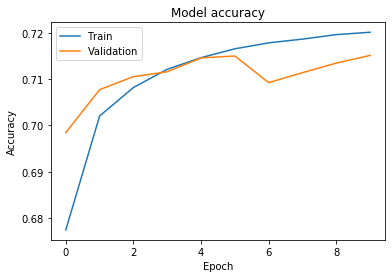

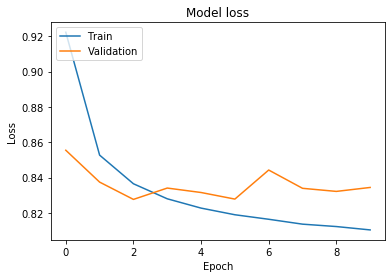

In [40]:


accuracyName = 'accuracyMiddlewindowQ2W19Model2.png'
lossName = 'lossMiddlewindowQ2W19Model2.png'

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig(accuracyName)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig(lossName)
plt.show()




In [ ]:

m.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
X_test = changeQ8Class(X_test, q8ClassToQ2, numberOfFeatures)
X_test_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_test, classSize)
X_test_window = removeWindowsWithPadding(X_test_window , windowSize, numberOfFeatures)
print(X_test_window.shape)


0
100
200
300


In [57]:
f = gzip.GzipFile('cb513_window19Q2.npy.gz', "w")
np.save(f, X_test_window)
f.close()

In [ ]:
f = gzip.GzipFile('cb513_window19Q2.npy.gz', "r")
X_test_window = np.load(f)

In [ ]:
c = get_tapped_one_dataset(X_test_window, windowSize, classSize)
print(c.shape)

In [63]:

x_test_final = X_test_window[:,:,(21+classSize):]
#x_test_final = X_test_window[:,:,0:21]
y_test_final = X_test_window[:,:,21: (21+classSize)]
print(x_test_final.shape)
print(y_test_final.shape)

(80631, 19, 21)
(80631, 19, 2)


In [31]:
y_test_final = np.reshape(y_test_final, (80119,19*8))
print(y_test_final.shape)
y_test_final = y_test_final[:,0:8]
print(y_test_final.shape)

(80119, 152)
(80119, 8)


In [41]:
scores = m.evaluate(x_test_final, y_test_final)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))
print("yes boi")

80119/80119 [==============================] - 45s 566us/step
Loss: 0.9475758478400143, Accuracy: 0.6715385913848877, MAE: 0.10705139487981796
yes boi


In [42]:
fold = 3
m.save('model_' + str(fold) + '.h5')  # creates a HDF5 file 
with open('model_scores_' + str(fold), 'wb') as file_pi:
    pickle.dump(scores, file_pi)
with open('model_history_' + str(fold), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)